In [4]:
import mpmath
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


def initialize_ashkin_teller_potential(J: float, M: float, max_s: int = 10) -> np.ndarray:
    """
    Initialize 2D Fourier coefficients for Ashkin-Teller model potential:
    u(θ_s, θ_t) = exp[J(cos θ_s + cos θ_t) + M(cos θ_s)(cos θ_t)]
    
    Args:
        J: Coupling strength for individual XY terms
        M: Coupling strength between XY models
        max_s: Maximum Fourier mode to track
    Returns:
        2D array of Fourier coefficients f(l_s, l_t) 
    """
    
    # Convert parameters to mpmath type
    J = mpmath.mpf(str(J))
    M = mpmath.mpf(str(M))
    
    # Initialize 2D array for (2*max_s + 1) x (2*max_s + 1) coefficients
    f = np.zeros((2*max_s + 1, 2*max_s + 1), dtype=object)
    
    # Number of points for numerical integration
    n_points = 200  # Reduced from 1000 due to 2D integration
    
    # Create meshgrid for θ_s and θ_t
    theta = [mpmath.mpf(t) for t in mpmath.linspace(0, 2*mpmath.pi, n_points)]
    dtheta = mpmath.mpf('2.0') * mpmath.pi / mpmath.mpf(str(n_points))
    theta_s, theta_t = np.meshgrid(theta, theta)
    
    # Compute potential u(θ_s, θ_t)
    u_theta = np.zeros((n_points, n_points), dtype=object)
    for i in range(n_points):
        for j in range(n_points):
            cos_theta_s = mpmath.cos(theta_s[i,j])
            cos_theta_t = mpmath.cos(theta_t[i,j])
            exponent = J * (cos_theta_s + cos_theta_t) + M * cos_theta_s * cos_theta_t
            u_theta[i,j] = mpmath.exp(exponent)
    
    # Compute 2D Fourier coefficients
    for idx_s, l_s in enumerate(range(-max_s, max_s + 1)):
        for idx_t, l_t in enumerate(range(-max_s, max_s + 1)):
            l_s = mpmath.mpf(str(l_s))
            l_t = mpmath.mpf(str(l_t))
            
            # Compute 2D Fourier integral
            integrand = np.zeros((n_points, n_points), dtype=object)
            for i in range(n_points):
                for j in range(n_points):
                    phase = -1j * (l_s * theta_s[i,j] + l_t * theta_t[i,j])
                    integrand[i,j] = u_theta[i,j] * mpmath.exp(phase)
            
            # Perform 2D integration
            f[idx_s, idx_t] = sum(sum(row) for row in integrand) * dtheta * dtheta / (4 * mpmath.pi**2)
    
    return f

def compute_g_2d(f: np.ndarray, max_s: int) -> np.ndarray:
    """
    Compute 2D convolution g(l_s, l_t) = Fourier transform of u²(θ_s, θ_t)
    Based on extension of Eq. 2.7b to 2D
    """
    g = np.zeros((2*max_s + 1, 2*max_s + 1), dtype=object)
    
    for idx_ls, l_s in enumerate(range(-max_s, max_s + 1)):
        for idx_lt, l_t in enumerate(range(-max_s, max_s + 1)):
            g_st = mpmath.mpc(0)
            
            # 2D convolution
            for p_s in range(-max_s, max_s + 1):
                for p_t in range(-max_s, max_s + 1):
                    q_s = l_s - p_s
                    q_t = l_t - p_t
                    
                    if abs(q_s) <= max_s and abs(q_t) <= max_s:
                        p_idx_s = p_s + max_s
                        p_idx_t = p_t + max_s
                        q_idx_s = q_s + max_s
                        q_idx_t = q_t + max_s
                        g_st += f[p_idx_s, p_idx_t] * f[q_idx_s, q_idx_t]
                        
            g[idx_ls, idx_lt] = g_st
            
    return g

def compute_A4_2d(g: np.ndarray) -> mpmath.mpf:
    """
    Compute A4 = Σ|g(l_s, l_t)|² for the 2D case
    Extension of Eq. 2.9 to 2D
    
    Args:
        g: 2D array of g coefficients
        
    Returns:
        Sum of squared magnitudes of g coefficients
    """
    return sum(g[ls, lt] * mpmath.conj(g[ls, lt]) 
              for ls in range(g.shape[0]) 
              for lt in range(g.shape[1]))

def rg_step_2d(f: np.ndarray, max_s: int) -> tuple[np.ndarray, mpmath.mpf]:
    """
    Perform one RG transformation step for the Ashkin-Teller model
    Extension of Eqs. 2.7a and 2.8 to 2D
    
    Args:
        f: 2D array of current Fourier coefficients
        max_s: Maximum Fourier mode
        
    Returns:
        tuple of:
        - New Fourier coefficients after RG step
        - Constant term for free energy calculation
    """
    # Compute g coefficients and A4
    g = compute_g_2d(f, max_s)
    A4 = compute_A4_2d(g)
    
    # Initialize new coefficients array
    f_new = np.zeros((2*max_s + 1, 2*max_s + 1), dtype=object)
    
    # Compute non-zero modes
    for idx_ls in range(2*max_s + 1):
        for idx_lt in range(2*max_s + 1):
            if idx_ls != max_s or idx_lt != max_s:  # Not the (0,0) mode
                f_new[idx_ls, idx_lt] = (g[idx_ls, idx_lt] * g[idx_ls, idx_lt]) / A4
    
    # Compute (0,0) mode from normalization condition
    # f(0,0) = 1 - sum of all other modes
    f_new[max_s, max_s] = mpmath.mpc(1.0) - sum(
        f_new[ls, lt] 
        for ls in range(2*max_s + 1) 
        for lt in range(2*max_s + 1) 
        if (ls != max_s or lt != max_s)
    )
    
    return f_new, mpmath.log(A4)

def rg_flow_2d(J: float, M: float, n_steps: int = 10, max_s: int = 10) -> tuple[np.ndarray, np.ndarray]:
    """
    Run RG transformation for n steps for the Ashkin-Teller model
    
    Args:
        J: Coupling strength for individual XY terms
        M: Coupling strength between XY models
        n_steps: Number of RG steps to perform
        max_s: Maximum Fourier mode to track
        
    Returns:
        tuple of:
        - Array of coefficient histories
        - Array of free energy contributions
    """
    # Initialize coefficients
    f = initialize_ashkin_teller_potential(J, M, max_s)
    
    # Track history of coefficients and free energy terms
    history = [f.copy()]
    G_terms = []
    
    # Perform RG steps
    for _ in range(n_steps):
        f, G = rg_step_2d(f, max_s)
        history.append(f.copy())
        G_terms.append(G)
        
    return np.array(history), np.array(G_terms)

def reconstruct_potential_2d(f: np.ndarray, max_s: int, n_points: int = 50) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Reconstruct u(θ_s, θ_t) from 2D Fourier coefficients
    
    Args:
        f: 2D array of Fourier coefficients
        max_s: Maximum Fourier mode
        n_points: Number of points for each angle dimension
        
    Returns:
        tuple of:
        - 2D array of θ_s values
        - 2D array of θ_t values
        - 2D array of potential values
    """
    # Create angle grids
    theta = [mpmath.mpf(t) for t in mpmath.linspace(0, 2*mpmath.pi, n_points)]
    theta_s, theta_t = np.meshgrid(theta, theta)
    
    # Initialize potential array
    u_theta = np.zeros((n_points, n_points), dtype=object)
    
    # Sum over all modes
    for i in range(n_points):
        for j in range(n_points):
            u_sum = mpmath.mpc(0)
            for idx_ls, l_s in enumerate(range(-max_s, max_s + 1)):
                for idx_lt, l_t in enumerate(range(-max_s, max_s + 1)):
                    phase = l_s * theta_s[i,j] + l_t * theta_t[i,j]
                    u_sum += f[idx_ls, idx_lt] * mpmath.exp(1j * phase)
            u_theta[i,j] = float(mpmath.re(u_sum))
    
    return theta_s, theta_t, u_theta

def plot_potential_evolution_2d(history: np.ndarray, J: float, M: float, 
                              n_plot_steps: int = 4, max_s: int = 10):
    """
    Visualize the evolution of the Ashkin-Teller potential under RG transformation
    using both 2D heatmaps and 3D surface plots.
    
    Args:
        history: Array of Fourier coefficients at each RG step
        J: Initial coupling strength for individual XY terms
        M: Initial coupling strength between XY models
        n_plot_steps: Number of RG steps to visualize
        max_s: Maximum Fourier mode used
    """
    # Select steps to plot
    steps_to_plot = np.linspace(0, len(history)-1, n_plot_steps).astype(int)
    
    # Create figure with both 2D and 3D subplots
    fig = plt.figure(figsize=(20, 5*n_plot_steps))
    
    for idx, step in enumerate(steps_to_plot):
        # Reconstruct potential for this RG step
        theta_s, theta_t, u_theta = reconstruct_potential_2d(history[step], max_s)
        
        # Convert theta_s and theta_t to float arrays for plotting
        theta_s_float = np.array([[float(val) for val in row] for row in theta_s])
        theta_t_float = np.array([[float(val) for val in row] for row in theta_t])
        u_theta_float = np.array([[float(val) for val in row] for row in u_theta])
        
        # 2D Heatmap
        ax1 = fig.add_subplot(n_plot_steps, 2, 2*idx + 1)
        im = ax1.imshow(u_theta_float, extent=[0, 2*np.pi, 0, 2*np.pi],
                       origin='lower', cmap='viridis')
        plt.colorbar(im, ax=ax1)
        ax1.set_xlabel(r'$\theta_s$')
        ax1.set_ylabel(r'$\theta_t$')
        ax1.set_title(f'RG Step {step} - Heatmap')
        
        # 3D Surface plot
        ax2 = fig.add_subplot(n_plot_steps, 2, 2*idx + 2, projection='3d')
        surf = ax2.plot_surface(theta_s_float, theta_t_float, u_theta_float, 
                              cmap=cm.viridis,
                              linewidth=0, antialiased=True)
        plt.colorbar(surf, ax=ax2)
        ax2.set_xlabel(r'$\theta_s$')
        ax2.set_ylabel(r'$\theta_t$')
        ax2.set_zlabel(r'$u(\theta_s,\theta_t)$')
        ax2.set_title(f'RG Step {step} - 3D Surface')
        ax2.view_init(elev=30, azim=45)  # Set viewing angle
        
    plt.suptitle(f'Evolution of Ashkin-Teller Potential (J={J}, M={M})', 
                 fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

def analyze_coupling_evolution(history: np.ndarray, max_s: int):
    """
    Analyze how the effective couplings evolve during RG flow
    by extracting coefficients related to J and M terms.
    
    Args:
        history: Array of Fourier coefficients at each RG step
        max_s: Maximum Fourier mode used
    """
    n_steps = len(history)
    
    # Track coefficients related to J and M
    J_eff = np.zeros(n_steps)  # Related to cos(θ_s) + cos(θ_t) terms
    M_eff = np.zeros(n_steps)  # Related to cos(θ_s)cos(θ_t) term
    
    for step in range(n_steps):
        # Extract relevant Fourier coefficients
        # f(±1,0) and f(0,±1) relate to J
        # f(±1,±1) relates to M
        J_coef = float(abs(history[step][max_s+1, max_s] + 
                         history[step][max_s-1, max_s] +
                         history[step][max_s, max_s+1] + 
                         history[step][max_s, max_s-1]))
        M_coef = float(abs(history[step][max_s+1, max_s+1] + 
                         history[step][max_s-1, max_s-1]))
        
        J_eff[step] = J_coef/4  # Average of the four J-related terms
        M_eff[step] = M_coef/2  # Average of the two M-related terms
    
    # Plot evolution of effective couplings
    plt.figure(figsize=(10, 6))
    plt.plot(J_eff, label='Effective J', marker='o')
    plt.plot(M_eff, label='Effective M', marker='s')
    plt.xlabel('RG Step')
    plt.ylabel('Effective Coupling Strength')
    plt.title('Evolution of Effective Couplings')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_coefficient_evolution(history: np.ndarray, J: float, M: float, max_s: int):
    """
    Visualize the evolution of Fourier coefficients during RG flow,
    focusing on physically meaningful coefficients that correspond to
    different types of couplings in the Ashkin-Teller model.
    
    The visualization tracks:
    - (0,0) mode: Overall normalization
    - (1,0) and (0,1) modes: Individual XY couplings (J terms)
    - (1,1) mode: Coupling between XY models (M term)
    
    Args:
        history: Array of Fourier coefficients at each RG step
        J: Initial coupling strength for XY terms
        M: Coupling strength between XY models
        max_s: Maximum Fourier mode tracked
    """
    # Create figure with appropriate size
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Define the modes to track and their physical meanings
    modes_to_track = [
        (max_s, max_s),      # (0,0) mode - normalization
        (max_s+1, max_s),    # (1,0) mode - J coupling in s direction
        (max_s, max_s+1),    # (0,1) mode - J coupling in t direction
        (max_s+1, max_s+1),  # (1,1) mode - M coupling
        (max_s+2, max_s),    # (2,0) mode - higher order coupling
        (max_s, max_s+2)     # (0,2) mode - higher order coupling
    ]
    
    labels = [
        r'$\lambda_{00}$ - Normalization', 
        r'$\lambda_{10}$ - J coupling (s direction)', 
        r'$\lambda_{01}$ - J coupling (t direction)', 
        r'$\lambda_{11}$ - M coupling',
        r'$\lambda_{20}$ - Higher order (s)',
        r'$\lambda_{02}$ - Higher order (t)'
    ]
    
    markers = ['o', 's', '^', 'D', 'v', '>']
    colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown']
    
    # Plot evolution of each coefficient
    for (i, j), label, marker, color in zip(modes_to_track, labels, markers, colors):
        coef_evolution = [float(abs(step[i,j])) for step in history]
        ax.plot(coef_evolution, label=label, marker=marker, 
                markersize=8, color=color, linewidth=2)
    
    # Customize the plot
    ax.set_xlabel('RG Step', fontsize=14)
    ax.set_ylabel('|Coefficient|', fontsize=14)
    ax.set_yscale('log')
    ax.set_title('Evolution of Ashkin-Teller Model Couplings\n'
                f'Initial Parameters: J={J}, M={M}', 
                fontsize=16, pad=20)
    
    # Add grid and legend
    ax.grid(True, which='both', linestyle='--', alpha=0.7)
    ax.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add RG flow direction indicator
    ax.text(0.02, 0.98, 'RG Flow →', transform=ax.transAxes,
            fontsize=12, verticalalignment='top')
    
    plt.tight_layout()
    plt.show()

def plot_coefficient_evolution_with_patterns(history: np.ndarray, J: float, M: float, max_s: int):
    """
    Visualize the evolution of Fourier coefficients during RG flow.
    Shows both the coefficient magnitudes and their 2D patterns.
    """
    n_steps = len(history)
    # Select 3 steps to show coefficient patterns (initial, middle, and final)
    steps_to_plot = [0, n_steps//2, n_steps-1]
    
    # Create figure with a 2x3 grid layout
    fig = plt.figure(figsize=(20, 12))
    
    # 1. Plot evolution of coefficients in the left column spans both rows
    ax1 = fig.add_subplot(131)
    
    # Track physically meaningful coefficients
    modes_to_track = [
        (max_s, max_s),      # (0,0) mode - normalization
        (max_s+1, max_s),    # (1,0) mode - J coupling in s direction
        (max_s, max_s+1),    # (0,1) mode - J coupling in t direction
        (max_s+1, max_s+1),  # (1,1) mode - M coupling
    ]
    labels = ['(0,0) - normalization', 
              '(1,0) - J coupling (s)', 
              '(0,1) - J coupling (t)', 
              '(1,1) - M coupling']
    
    for (i, j), label in zip(modes_to_track, labels):
        coef_evolution = [float(abs(step[i,j])) for step in history]
        ax1.plot(coef_evolution, label=label, marker='o', markersize=6)
    
    ax1.set_xlabel('RG Step', fontsize=12)
    ax1.set_ylabel('|Coefficient|', fontsize=12)
    ax1.set_yscale('log')
    ax1.set_title('Evolution of Key Fourier Coefficients', fontsize=14)
    ax1.legend(fontsize=10)
    ax1.grid(True)
    
    # 2. Plot coefficient patterns at selected steps
    for idx, step in enumerate(steps_to_plot):
        # Place patterns in positions 2, 3, 5, 6 of the 2x3 grid
        ax = fig.add_subplot(1, 3, idx+2)
        
        # Convert coefficients to magnitude array for plotting
        coef_magnitudes = np.array([[float(abs(history[step][i,j])) 
                                   for j in range(2*max_s+1)]
                                  for i in range(2*max_s+1)])
        
        # Add small constant to avoid log(0)
        min_nonzero = np.min(coef_magnitudes[coef_magnitudes > 0])
        coef_magnitudes = coef_magnitudes + min_nonzero * 1e-10
        
        # Plot as heatmap with logarithmic color scale
        im = ax.imshow(coef_magnitudes, 
                      norm=LogNorm(vmin=coef_magnitudes.min(), 
                                 vmax=coef_magnitudes.max()),
                      cmap='viridis')
        plt.colorbar(im, ax=ax)
        
        # Add mode numbers to axes
        mode_labels = list(range(-max_s, max_s+1))
        ax.set_xticks(range(len(mode_labels)))
        ax.set_yticks(range(len(mode_labels)))
        ax.set_xticklabels(mode_labels)
        ax.set_yticklabels(mode_labels)
        
        ax.set_xlabel('l_t mode', fontsize=10)
        ax.set_ylabel('l_s mode', fontsize=10)
        ax.set_title(f'Coefficient Pattern at Step {step}', fontsize=12)
    
    plt.suptitle(f'Evolution of Ashkin-Teller Fourier Coefficients\nJ={J}, M={M}', 
                 fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

In [97]:
# Set precision
mpmath.mp.dps = 50

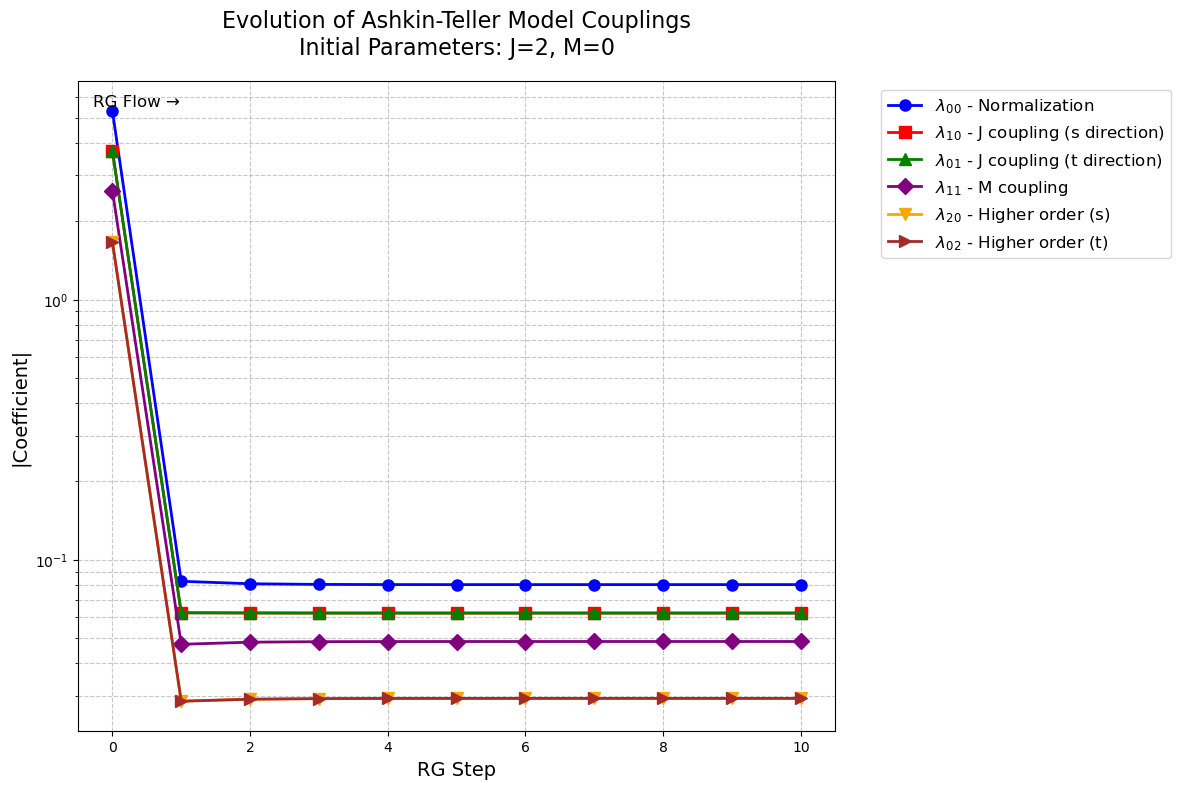

In [6]:
J = 2  # Initial XY coupling
M = 0  # Initial coupling between XY models
n_steps = 10
max_s = 5

history, G_terms = rg_flow_2d(J, M, n_steps, max_s)
plot_coefficient_evolution(history, J, M, max_s)

ValueError: num must be an integer with 1 <= num <= 3, not 4

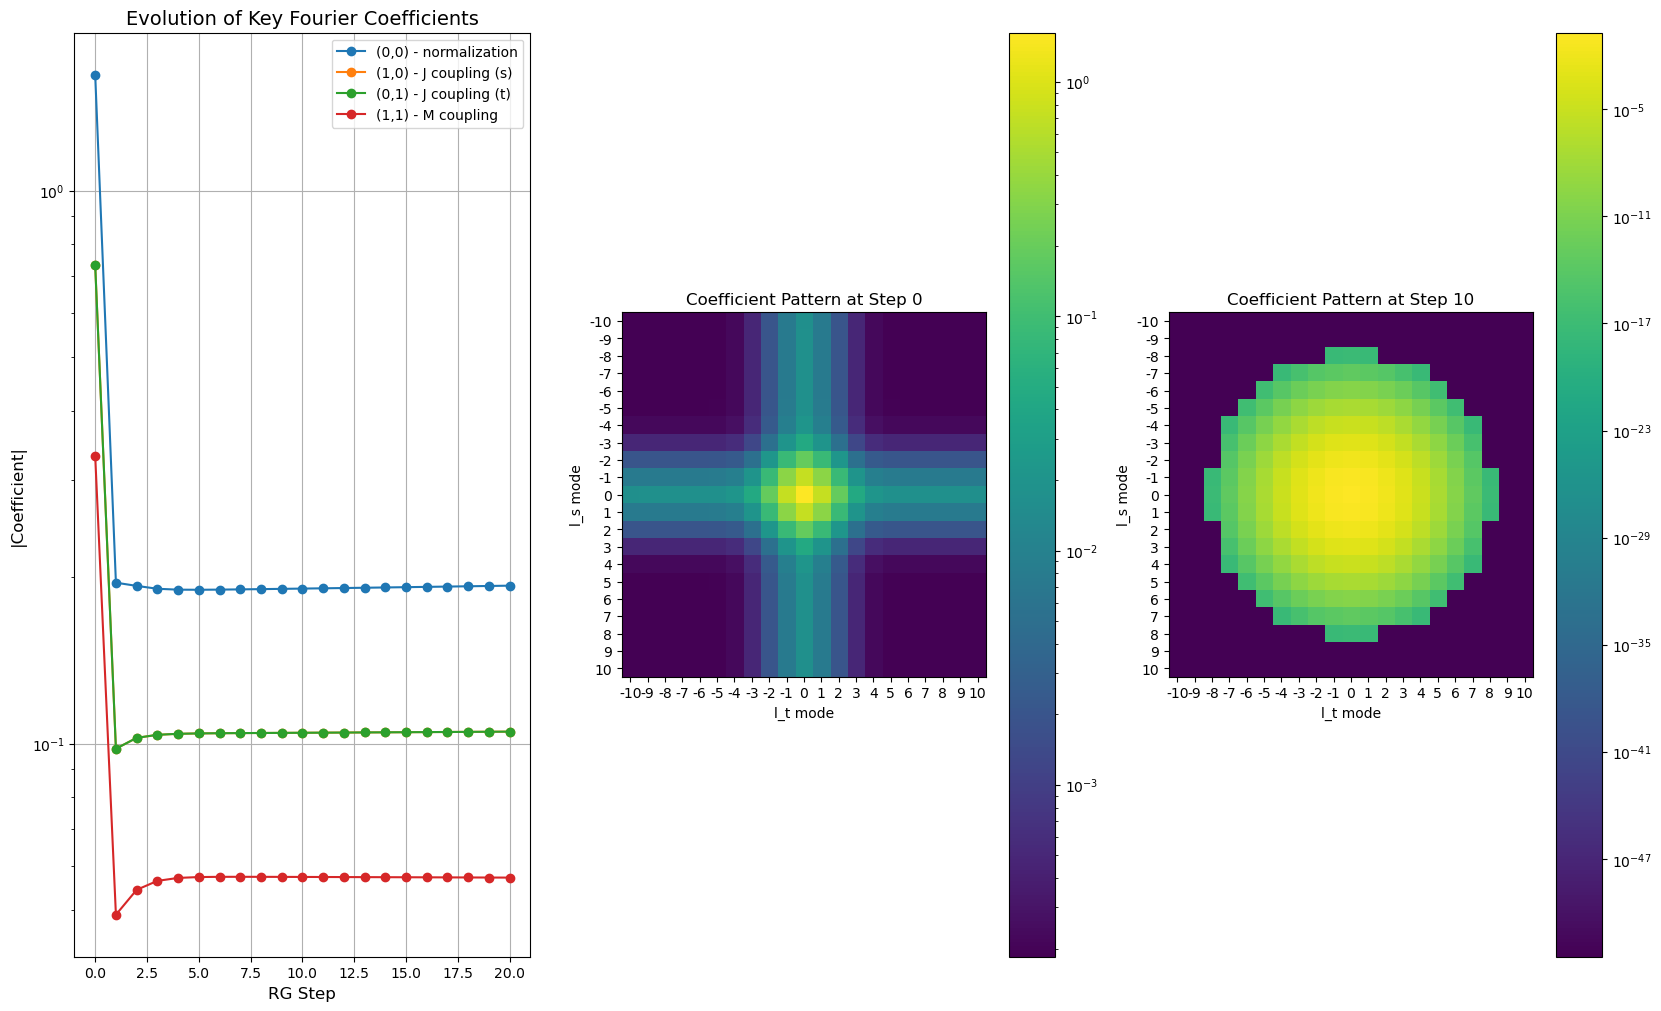

In [24]:
plot_coefficient_evolution_with_patterns(history, J, M, max_s)

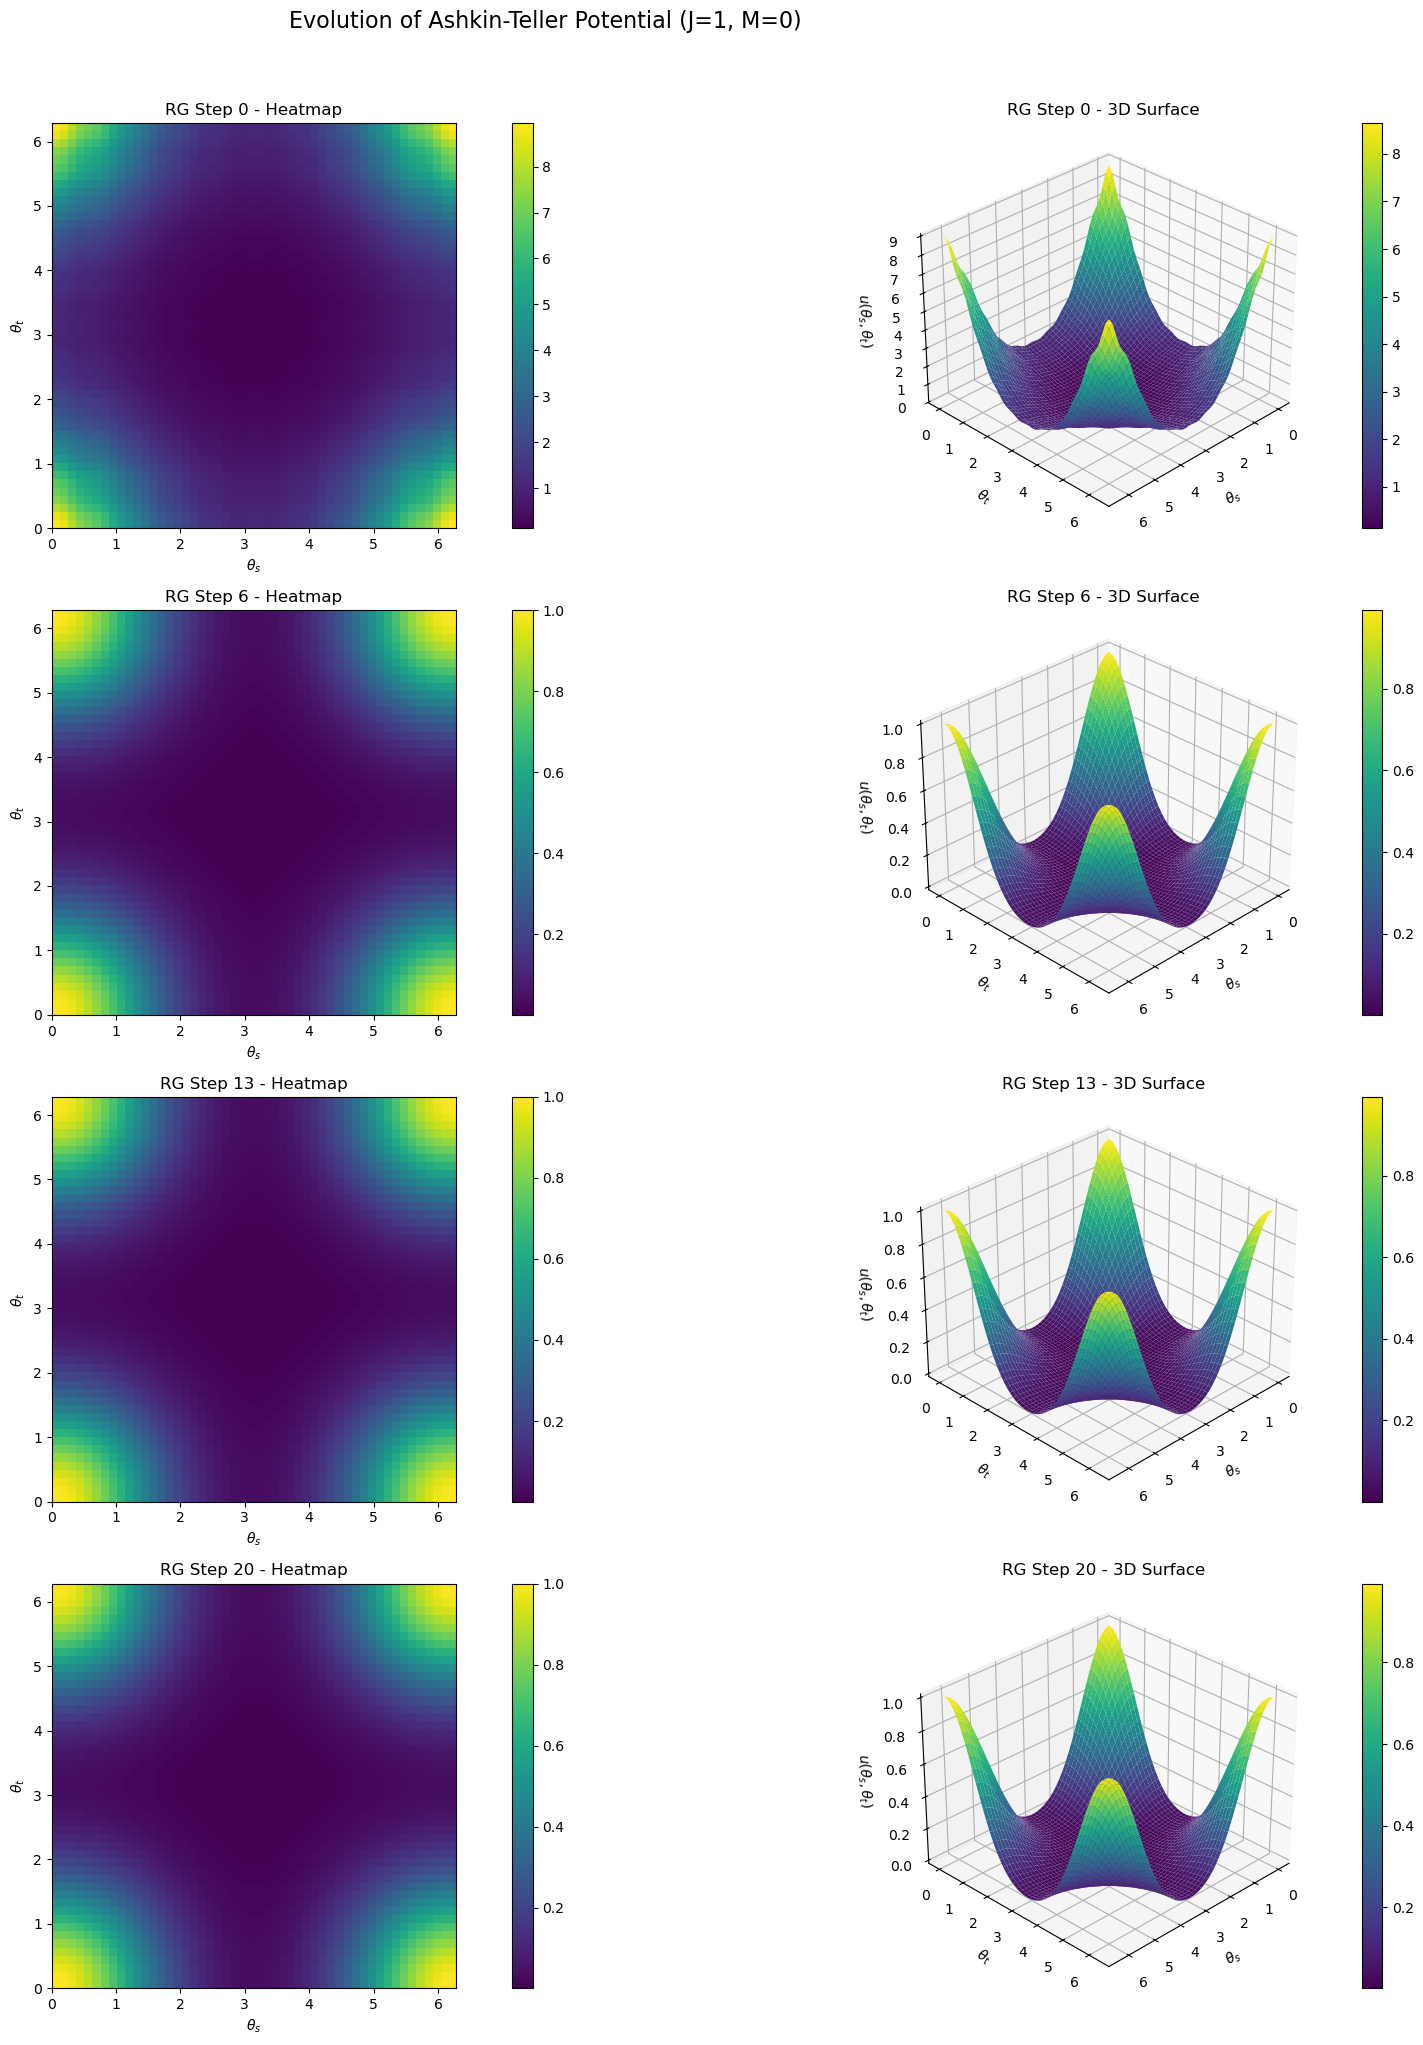

In [21]:
# Visualize potential evolution
plot_potential_evolution_2d(history, J, M)